<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/CoarseOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Colab setup ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


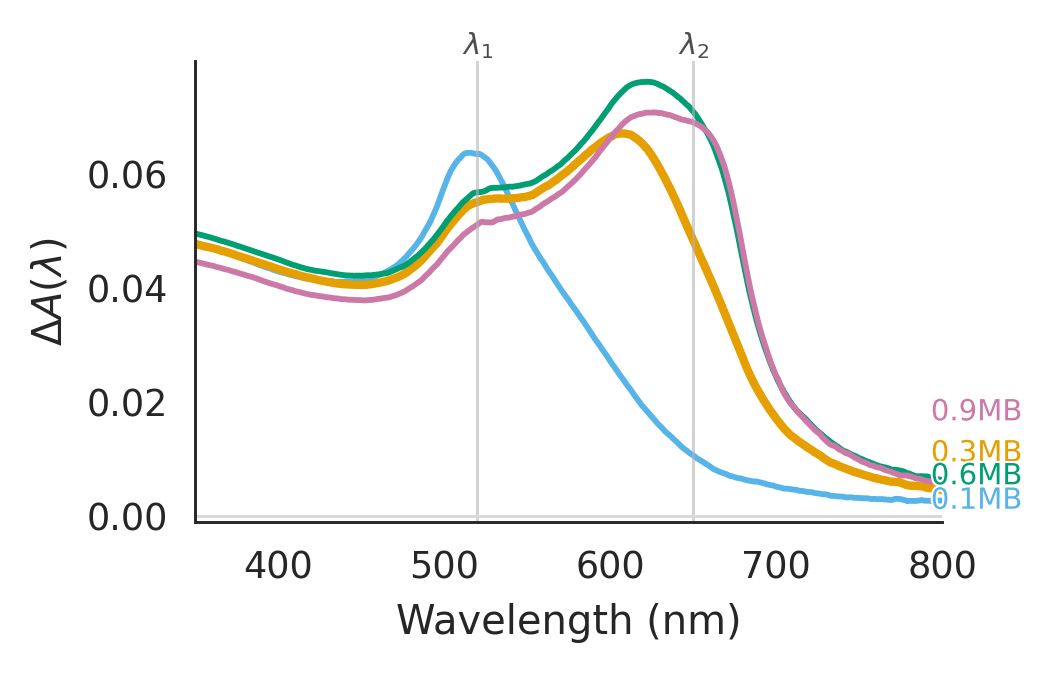

Saved:
/content/drive/MyDrive/RegeneronSTS/figures/coarse_pass_diff_clean.png
/content/drive/MyDrive/RegeneronSTS/figures/coarse_pass_diff_clean.pdf


In [3]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from pathlib import Path
import matplotlib.patheffects as pe
import sys

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

# Cuvette pathlength in cm. If not 1.0, spectra are scaled to 1.0 cm.
PATHLENGTH_CM = 1.0

# Exact dilution factors k = V0 / Vf
k_by_loading = {
    "0.1MB": 0.671053,
    "0.3MB": 0.679487,
    "0.6MB": 0.691358,
    "0.9MB": 0.702381,
}

# Grid and smoothing
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
SMOOTH = True
SG_WINDOW = 11   # odd
SG_POLY   = 2

# ==== Load data ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
if "Wavelength" not in df.columns:
    raise ValueError("Wavelength column not found in CSV")

df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

# Expected pairs: "<tag>_AuNP" and "<tag>_AuNP_As"
tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = []
missing = []
for tag in tags:
    bcol = f"{tag}_AuNP"
    acol = f"{tag}_AuNP_As"
    if bcol in df.columns and acol in df.columns:
        pairs.append((tag, bcol, acol))
    else:
        missing.append((tag, bcol, acol))
if missing:
    print("Warning: missing column pairs for tags:", missing, file=sys.stderr)

# ==== Helpers ====
grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(wl_src, A_src, wl_tgt):
    return np.interp(wl_tgt, wl_src, A_src)

def normalize_pathlength(A, path_cm):
    return A if path_cm == 1.0 else A * (1.0 / path_cm)

# ==== Build ΔA for each loading (no 800–900 baseline step) ====
recs = []
wl_src = df["Wavelength"].to_numpy()

for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])

    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    # Pathlength normalization
    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    # Interpolate to 1 nm grid 350–800
    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    # Dilution-corrected difference (no baseline subtraction)
    dA = A_as_g - k * A_blank_g

    # Light, uniform smoothing
    if SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    recs.append(pd.DataFrame({"Wavelength": grid, "dA": dA, "Loading": tag}))

if not recs:
    raise RuntimeError("No valid loading pairs were found to plot.")

dA_df = pd.concat(recs, ignore_index=True)

# ==== Plot per clean brief ====
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
PNG = f"{OUT_DIR}/coarse_pass_diff_clean.png"
PDF = f"{OUT_DIR}/coarse_pass_diff_clean.pdf"

# Figure size 90 mm x 58 mm at 300 dpi
inch = 1 / 25.4
fig_w, fig_h = 90 * inch, 58 * inch

sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 8,
    "axes.linewidth": 0.7,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
})

# Okabe–Ito colors in requested order
colors = {
    "0.1MB": "#56B4E9",
    "0.3MB": "#E69F00",
    "0.6MB": "#009E73",
    "0.9MB": "#CC79A7",
}
order = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Plot traces
for tag in order:
    sub = dA_df[dA_df["Loading"] == tag]
    if sub.empty:
        continue
    lw = 2.0 if tag == "0.3MB" else 1.4
    ax.plot(sub["Wavelength"], sub["dA"], color=colors[tag], lw=lw, label=tag)

# Vertical hairlines for λ1=520 and λ2=650
# Use natural y-limits after plotting to place labels accurately
ax.set_xlim(GRID_MIN, GRID_MAX)
ymin = float(np.nanmin(dA_df["dA"]))
ymax = float(np.nanmax(dA_df["dA"]))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

for x, lab in [(520, r"$\lambda_1$"), (650, r"$\lambda_2$")]:
    ax.axvline(x, color="0.7", lw=0.7, alpha=0.6)
    ax.text(x, ax.get_ylim()[1], lab, ha="center", va="bottom", fontsize=7, color="0.3")

# Axes, ticks, labels
ax.set_xticks([400, 500, 600, 700, 800])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$\Delta A(\lambda)$")

# Subtle y=0 reference line
ax.axhline(0.0, color="0.85", lw=0.7)

# Direct labels near right edge
x_label = 790
used_y = []
for tag in order:
    sub = dA_df[dA_df["Loading"] == tag]
    if sub.empty:
        continue
    idx = (sub["Wavelength"] - x_label).abs().argmin()
    xv = float(sub.iloc[idx]["Wavelength"])
    yv = float(sub.iloc[idx]["dA"])
    nudge = 0.0
    for taken in used_y:
        if abs((yv + nudge) - taken) < 0.004:
            nudge += 0.006
    used_y.append(yv + nudge)
    ax.text(xv + 3, yv + nudge, tag, color=colors[tag], fontsize=7,
            va="center", ha="left",
            path_effects=[pe.withStroke(linewidth=1.0, foreground="white")])

# Clean look
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(PNG, dpi=300, bbox_inches="tight")
plt.savefig(PDF, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:")
print(PNG)
print(PDF)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


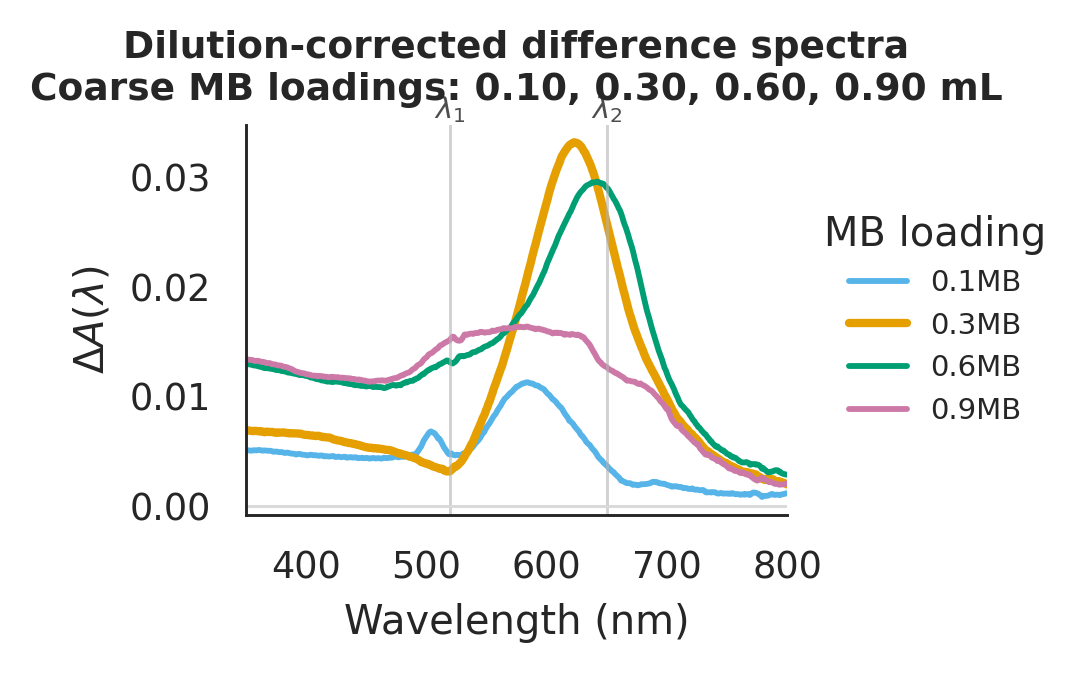

Saved:
/content/drive/MyDrive/RegeneronSTS/figures/coarse_pass_diff_with_legend.png
/content/drive/MyDrive/RegeneronSTS/figures/coarse_pass_diff_with_legend.pdf


In [7]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from pathlib import Path

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

# Cuvette pathlength in cm. If not 1.0, spectra are scaled to 1.0 cm.
PATHLENGTH_CM = 1.0

# Exact dilution factors k = V0 / Vf
k_by_loading = {
    "0.1MB": 1,
    "0.3MB": 1,
    "0.6MB": 1,
    "0.9MB": 1,
}

# Grid and smoothing
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
SMOOTH = True
SG_WINDOW = 11   # odd
SG_POLY   = 2

# ==== Load data ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = [(tag, f"{tag}_AuNP", f"{tag}_AuNP_As")
         for tag in tags if f"{tag}_AuNP" in df.columns and f"{tag}_AuNP_As" in df.columns]

# ==== Helpers ====
grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(wl_src, A_src, wl_tgt):
    return np.interp(wl_tgt, wl_src, A_src)

def normalize_pathlength(A, path_cm):
    return A if path_cm == 1.0 else A * (1.0 / path_cm)

# ==== Build ΔA for each loading ====
recs = []
wl_src = df["Wavelength"].to_numpy()

for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    # Normalize and interpolate
    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)
    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    # Difference (no baseline correction)
    dA = A_as_g - k * A_blank_g

    if SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    recs.append(pd.DataFrame({"Wavelength": grid, "dA": dA, "Loading": tag}))

dA_df = pd.concat(recs, ignore_index=True)

# ==== Plot ====
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
PNG = f"{OUT_DIR}/coarse_pass_diff_with_legend.png"
PDF = f"{OUT_DIR}/coarse_pass_diff_with_legend.pdf"

inch = 1 / 25.4
fig_w, fig_h = 90 * inch, 58 * inch

sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 8,
    "axes.linewidth": 0.7,
})

# Okabe–Ito colors
colors = {
    "0.1MB": "#56B4E9",
    "0.3MB": "#E69F00",
    "0.6MB": "#009E73",
    "0.9MB": "#CC79A7",
}
order = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

for tag in order:
    sub = dA_df[dA_df["Loading"] == tag]
    lw = 2.0 if tag == "0.3MB" else 1.4
    ax.plot(sub["Wavelength"], sub["dA"], color=colors[tag], lw=lw, label=tag)

# Vertical hairlines for λ1=520 and λ2=650
ymin = float(np.nanmin(dA_df["dA"]))
ymax = float(np.nanmax(dA_df["dA"]))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)
for x, lab in [(520, r"$\lambda_1$"), (650, r"$\lambda_2$")]:
    ax.axvline(x, color="0.7", lw=0.7, alpha=0.6)
    ax.text(x, ax.get_ylim()[1], lab, ha="center", va="bottom", fontsize=7, color="0.3")

# Axes, ticks, labels
ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_xticks([400, 500, 600, 700, 800])
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$\Delta A(\lambda)$")
ax.axhline(0.0, color="0.85", lw=0.7)

# Legend outside right
ax.legend(title="MB loading",
          frameon=False,
          loc="center left",
          bbox_to_anchor=(1.02, 0.5),
          fontsize=7)

# Title
ax.set_title("Dilution-corrected difference spectra\nCoarse MB loadings: 0.10, 0.30, 0.60, 0.90 mL",
             fontsize=9, weight="bold")

sns.despine(ax=ax)
plt.tight_layout()

plt.savefig(PNG, dpi=300, bbox_inches="tight")
plt.savefig(PDF, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:")
print(PNG)
print(PDF)

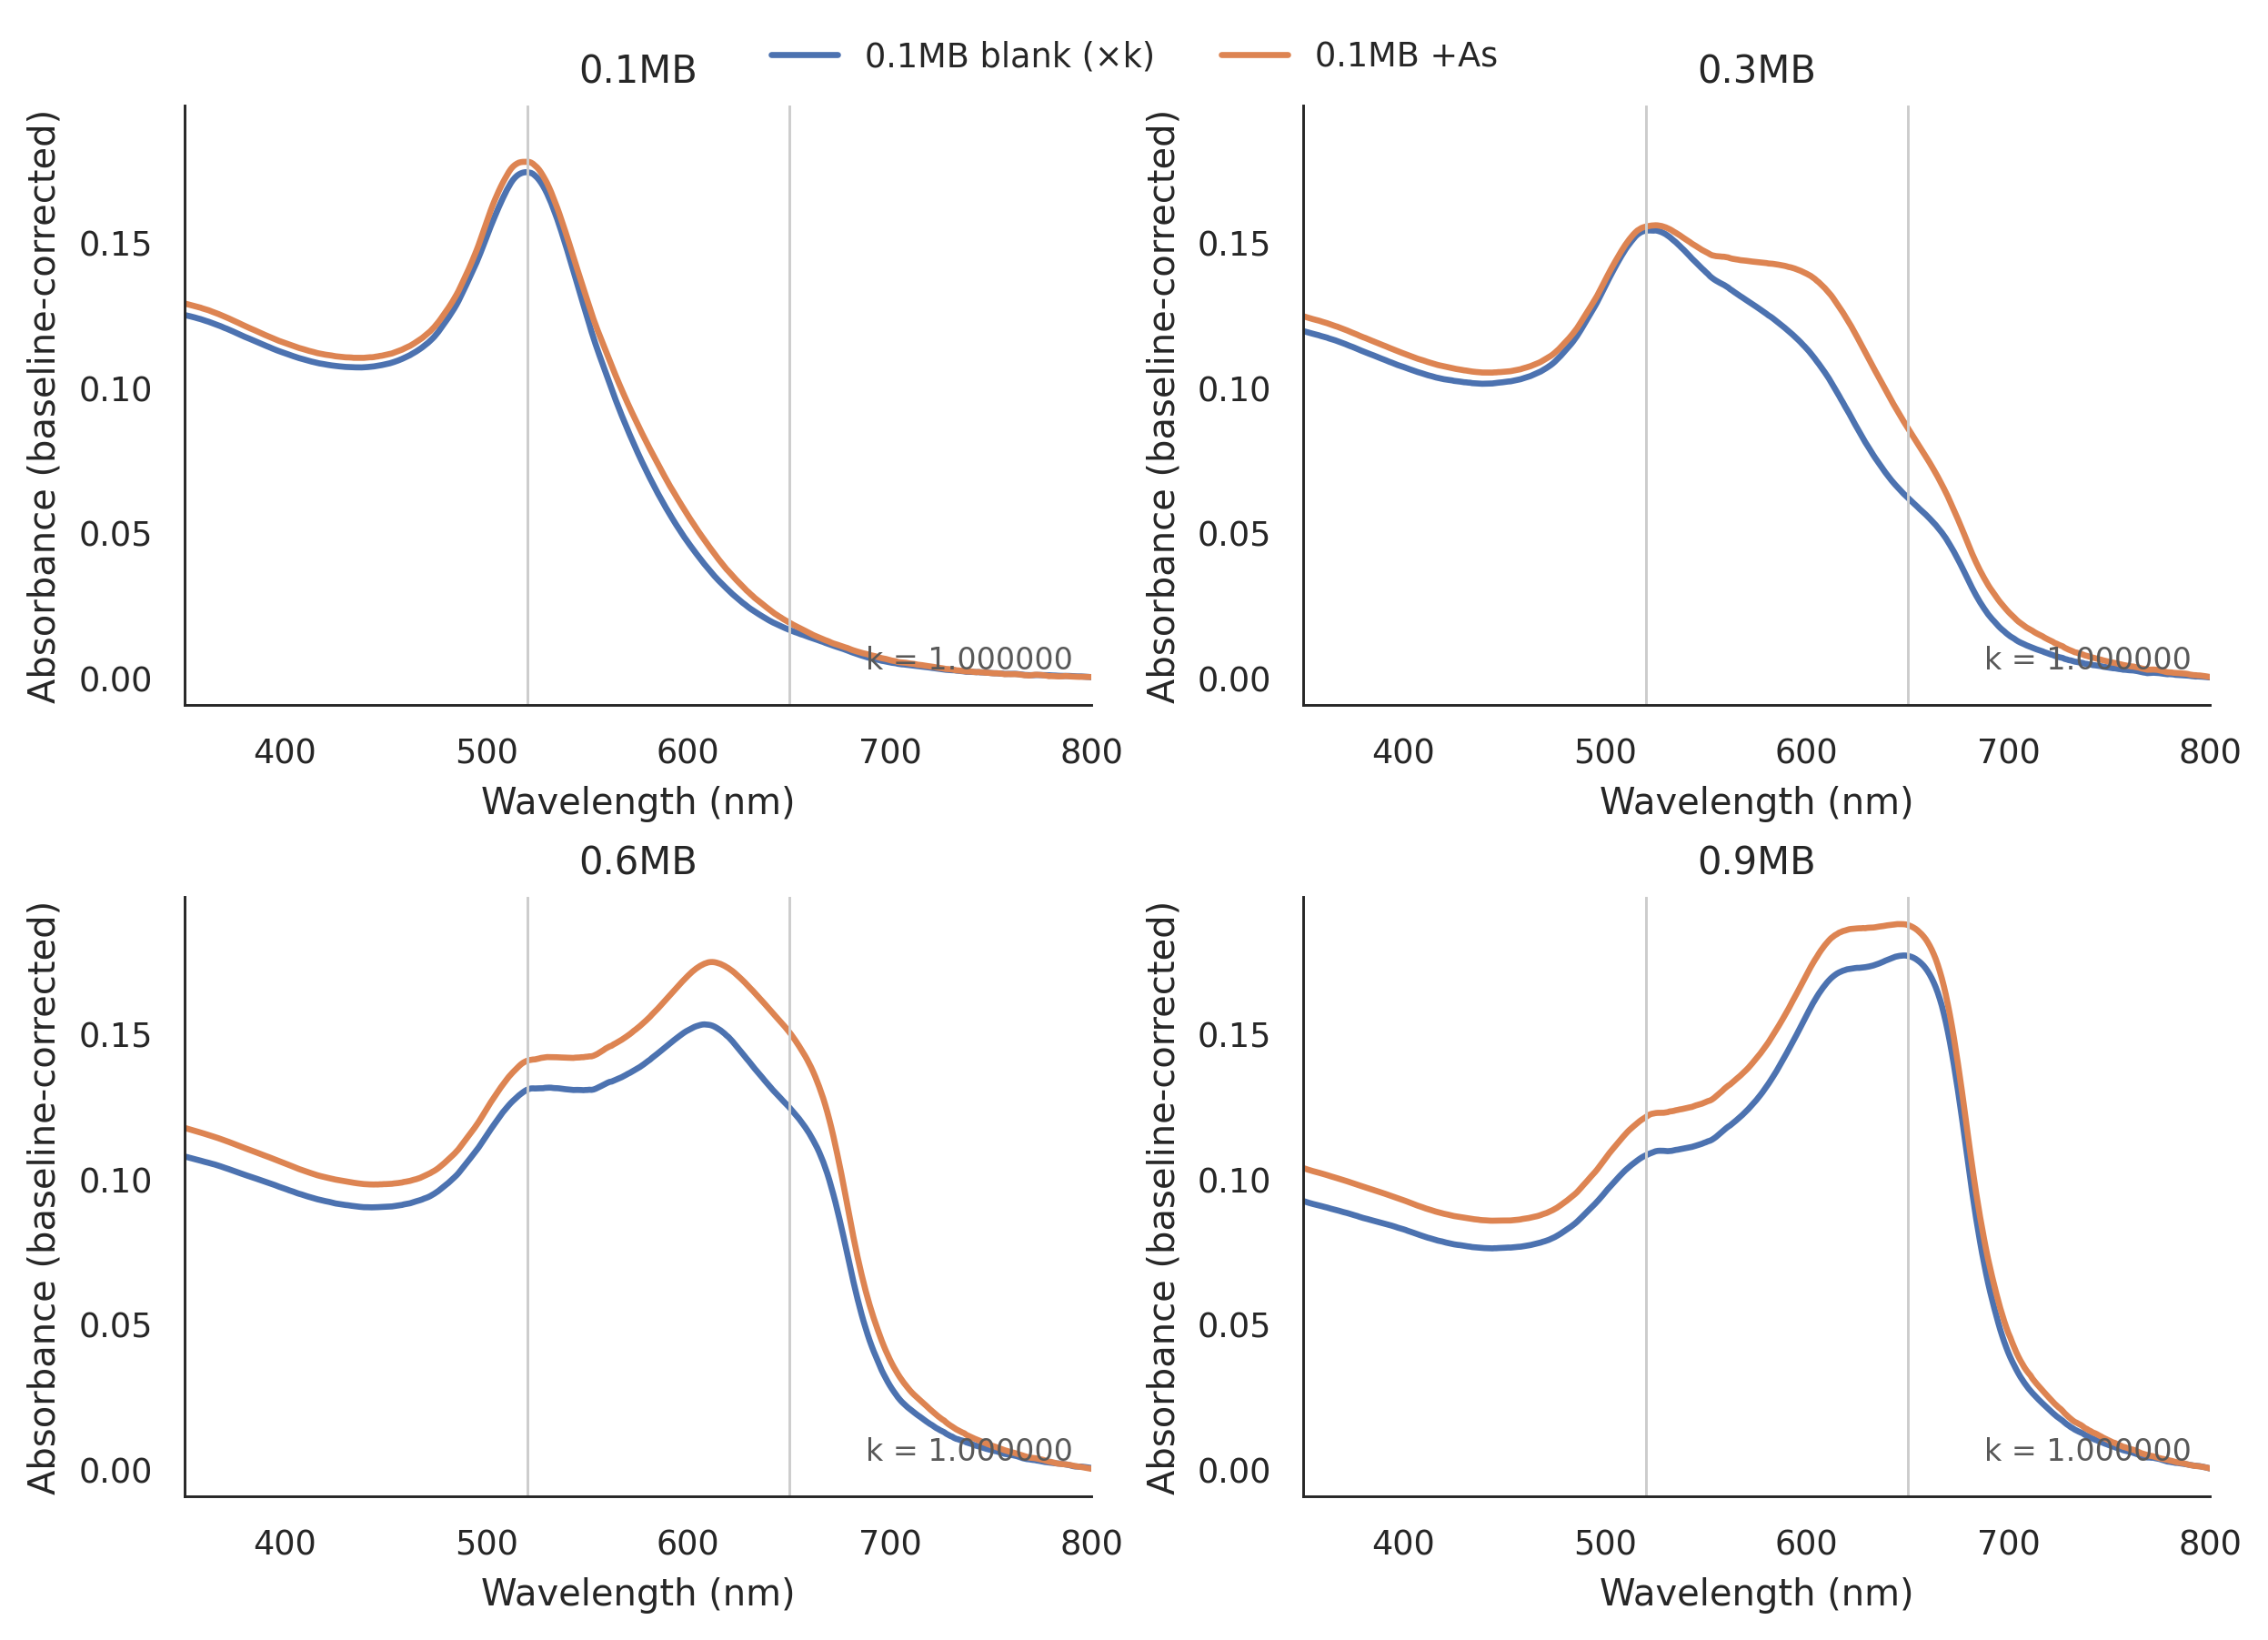

In [6]:
# ==== Colab plotting cell: coarse pass (4 subplots) ====

# Mount if needed
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ========= Inputs =========
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
PATHLENGTH_CM = 1.0           # set your cuvette pathlength in cm (1.0 for 10 mm)
USE_SMOOTHING = True
SG_WINDOW, SG_POLY = 11, 2    # light smoothing, identical for all traces
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1

# MB loadings to show (column name pattern: <tag>_AuNP, <tag>_AuNP_As)
tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]

# Exact dilution factors k = V0 / Vf (from your volume table)
k_by_loading = {
    "0.1MB": 1,  # V0 = 5.10 mL, Vf = 7.60 mL
    "0.3MB": 1,  # V0 = 5.30 mL, Vf = 7.80 mL
    "0.6MB": 1,  # V0 = 5.60 mL, Vf = 8.10 mL
    "0.9MB": 1,  # V0 = 5.90 mL, Vf = 8.40 mL
}

# ========= Load and prep =========
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

def interp_to_grid(x, y, grid):
    return np.interp(grid, x, y)

def baseline_correct(A, wl, wmin=800, wmax=900):
    mask = (wl >= wmin) & (wl <= wmax)
    if mask.sum() == 0:
        return A
    return A - np.nanmean(A[mask])

def normalize_pathlength(A, l_cm):
    return A if l_cm == 1.0 else A * (1.0 / l_cm)

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

# Collect all panels first to compute shared y-lims
panels = []
for tag in tags:
    bcol, acol = f"{tag}_AuNP", f"{tag}_AuNP_As"
    if bcol not in df.columns or acol not in df.columns:
        raise ValueError(f"Missing columns for {tag}: {bcol} or {acol}")

    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    # Pathlength normalize
    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    # Interp to common grid
    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    # Baseline correct both (same window)
    A_blank_g = baseline_correct(A_blank_g, grid)
    A_as_g    = baseline_correct(A_as_g,    grid)

    # Dilution-adjust the blank (scale by k)
    k = float(k_by_loading[tag])
    A_blank_scaled = k * A_blank_g

    # Optional smoothing
    if USE_SMOOTHING and len(grid) >= SG_WINDOW:
        A_blank_scaled = savgol_filter(A_blank_scaled, SG_WINDOW, SG_POLY, mode="interp")
        A_as_g         = savgol_filter(A_as_g,         SG_WINDOW, SG_POLY, mode="interp")

    panels.append((tag, grid, A_blank_scaled, A_as_g, k))

# Shared y-limits
ymin = min(np.nanmin(np.r_[p[2], p[3]]) for p in panels)
ymax = max(np.nanmax(np.r_[p[2], p[3]]) for p in panels)
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ylims = (ymin - pad, ymax + pad)

# ========= Plot (2x2 subplots) =========
fig, axes = plt.subplots(2, 2, figsize=(8.2, 5.8), dpi=300, constrained_layout=True)
axes = axes.ravel()

for ax, (tag, wl, A_blank_scaled, A_as_g, k) in zip(axes, panels):
    ax.plot(wl, A_blank_scaled, label=f"{tag} blank (×k)", lw=1.6)
    ax.plot(wl, A_as_g,         label=f"{tag} +As",       lw=1.6)

    # Vertical reference lines at λ1≈520 nm and λ2≈650 nm
    for x in (520, 650):
        ax.axvline(x, color="0.8", lw=0.7)

    ax.set_xlim(GRID_MIN, GRID_MAX)
    ax.set_ylim(*ylims)
    ax.set_xticks([400, 500, 600, 700, 800])
    ax.set_title(tag, fontsize=10)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Absorbance (baseline-corrected)")

    # Small note with k value
    ax.text(0.98, 0.05, f"k = {k:.6f}", ha="right", va="bottom", transform=ax.transAxes, fontsize=8, color="0.35")

    # Clean look
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Single legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.02))

plt.show()


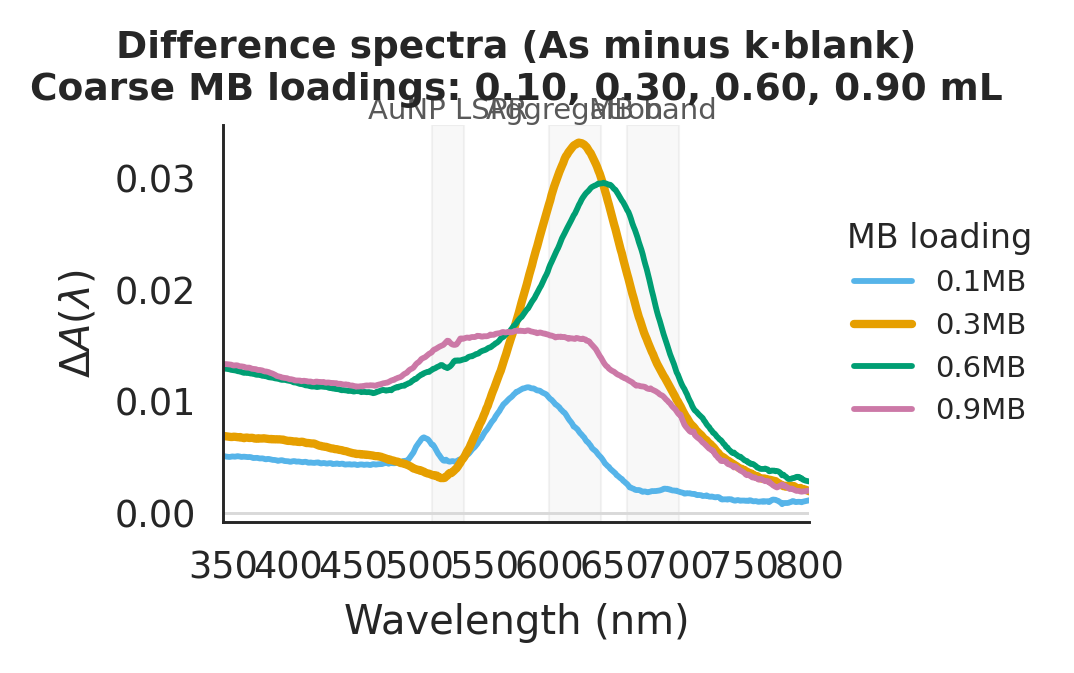

Saved: /content/drive/MyDrive/RegeneronSTS/figures/difference_spectra_hero_shaded.png /content/drive/MyDrive/RegeneronSTS/figures/difference_spectra_hero_shaded.pdf


In [9]:
# ==== Colab cell: difference spectra with three shaded regions ====

# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path
import seaborn as sns

# ===== Inputs =====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

PATHLENGTH_CM = 1.0
k_by_loading = {"0.1MB": 1.0, "0.3MB": 1.0, "0.6MB": 1.0, "0.9MB": 1.0}  # set V0/Vf here if you want

GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
USE_SMOOTH = True
SG_WINDOW, SG_POLY = 11, 2

# Chemistry windows
LSPR_BAND = (510, 535)   # AuNP plasmon band
AGG_BAND  = (600, 640)   # aggregation window
MB_BAND   = (660, 700)   # MB band
L1 = 522                 # measured AuNP plasmon for this dataset (for caption context)

# ===== Load and prep =====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = [(t, f"{t}_AuNP", f"{t}_AuNP_As")
         for t in tags if f"{t}_AuNP" in df.columns and f"{t}_AuNP_As" in df.columns]

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def normalize_pathlength(A, l_cm):
    return A if l_cm == 1.0 else A * (1.0 / l_cm)

# Build ΔA(λ)
curves = []
for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    dA = A_as_g - k * A_blank_g
    if USE_SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    curves.append((tag, dA))

dA_all = np.vstack([c[1] for c in curves])
ymin, ymax = float(np.nanmin(dA_all)), float(np.nanmax(dA_all))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
ylims = (ymin - pad, ymax + pad)

# ===== Plot =====
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
PNG = f"{OUT_DIR}/difference_spectra_hero_shaded.png"
PDF = f"{OUT_DIR}/difference_spectra_hero_shaded.pdf"

inch = 1 / 25.4
fig_w, fig_h = 90 * inch, 58 * inch

sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 8,         # base font size
    "axes.linewidth": 0.7,
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,
    "xtick.minor.size": 2.0,
    "ytick.minor.size": 2.0,
})

# Okabe–Ito colors
colors = {"0.1MB": "#56B4E9", "0.3MB": "#E69F00", "0.6MB": "#009E73", "0.9MB": "#CC79A7"}
order  = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]

fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Shaded regions first
def shade(ax, x0, x1, label):
    ax.axvspan(x0, x1, color="0.85", alpha=0.18, lw=0.5, ec="0.75")
    ax.text((x0+x1)/2, ylims[1], label, ha="center", va="bottom", fontsize=7, color="0.35")

shade(ax, *LSPR_BAND, "AuNP LSPR")
shade(ax, *AGG_BAND,  "Aggregation")
shade(ax, *MB_BAND,   "MB band")

# Curves
for tag in order:
    dA = dict(curves)[tag]
    lw = 2.0 if tag == "0.3MB" else 1.4
    ax.plot(grid, dA, color=colors[tag], lw=lw, label=tag)

# Axes, ticks, labels
ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_ylim(*ylims)
ax.set_xticks([350, 400, 450, 500, 550, 600, 650, 700, 750, 800])
ax.set_xticks(np.arange(350, 801, 25), minor=True)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$\Delta A(\lambda)$")
ax.axhline(0.0, color="0.85", lw=0.7)

# Legend and title
ax.legend(title="MB loading", frameon=False, loc="center left",
          bbox_to_anchor=(1.02, 0.5), fontsize=7, title_fontsize=8)
ax.set_title("Difference spectra (As minus k·blank)\nCoarse MB loadings: 0.10, 0.30, 0.60, 0.90 mL",
             fontsize=9, weight="bold")

# Cleanup
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
sns.despine(ax=ax)
plt.tight_layout()

plt.savefig(PNG, dpi=300, bbox_inches="tight")
plt.savefig(PDF, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", PNG, PDF)


#Finalized Version

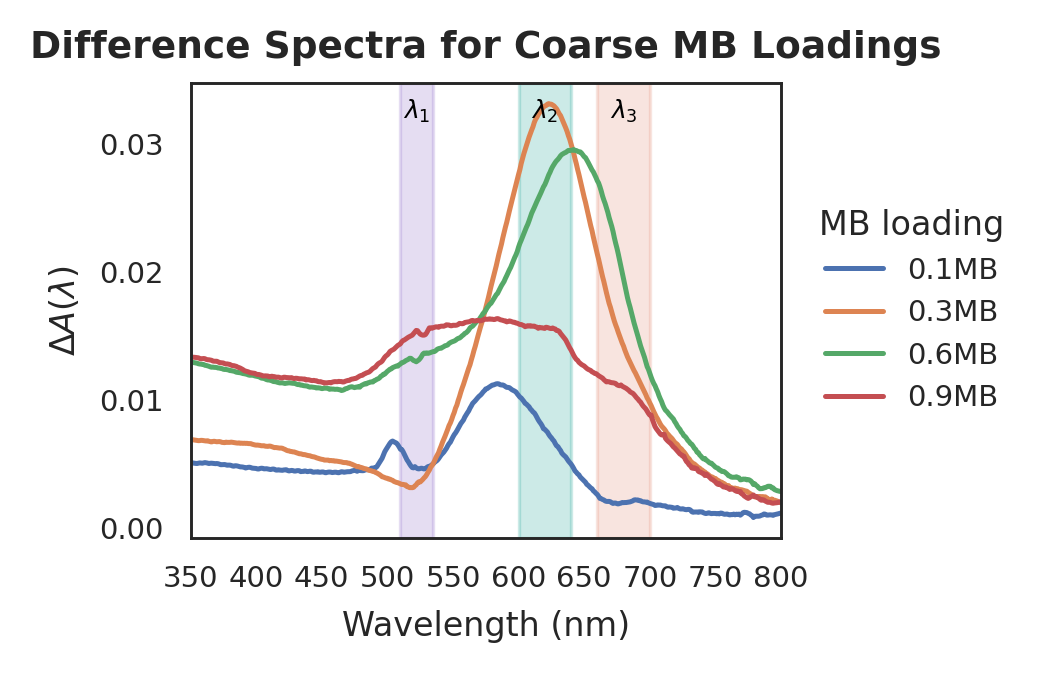

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path

# ===== Inputs =====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

PATHLENGTH_CM = 1.0
k_by_loading = {"0.1MB": 1.0, "0.3MB": 1.0, "0.6MB": 1.0, "0.9MB": 1.0}

GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
USE_SMOOTH = True
SG_WINDOW, SG_POLY = 11, 2

# Bands
LSPR_BAND = (510, 535)
AGG_BAND  = (600, 640)
MB_BAND   = (660, 700)

# ===== Load and prep =====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = [(t, f"{t}_AuNP", f"{t}_AuNP_As")
         for t in tags if f"{t}_AuNP" in df.columns and f"{t}_AuNP_As" in df.columns]

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def normalize_pathlength(A, l_cm):
    return A if l_cm == 1.0 else A * (1.0 / l_cm)

curves = []
for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    dA = A_as_g - k * A_blank_g
    if USE_SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    curves.append((tag, dA))

dA_all = np.vstack([c[1] for c in curves])
ymin, ymax = float(np.nanmin(dA_all)), float(np.nanmax(dA_all))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)

# ===== Plot =====
inch = 1/25.4
fig, ax = plt.subplots(figsize=(90*inch, 58*inch), dpi=300)

# Shaded regions
ax.axvspan(*LSPR_BAND, color="#7E57C2", alpha=0.2)
ax.axvspan(*AGG_BAND,  color="#009688", alpha=0.2)
ax.axvspan(*MB_BAND,   color="#E07A5F", alpha=0.2)

'''
band_specs = [
    ("Band I (λ$_1$)  LSPR",  LSPR_BAND, "#7E57C2"),  # purple
    ("Band II (λ$_2$) Agg.",  AGG_BAND,  "#009688"),  # teal
    ("Band III (λ$_3$) MB Q", MB_BAND,   "#E07A5F"),  # terracotta
]
'''

# Label shaded bands with lambda notation
for band, label in zip([LSPR_BAND, AGG_BAND, MB_BAND],
                       [r"$\lambda_1$", r"$\lambda_2$", r"$\lambda_3$"]):
    xpos = np.mean(band)
    ypos = ymax * 0.95  # 5% above max signal
    ax.text(xpos, ypos, label,
            ha="center", va="bottom",
            fontsize=6, fontweight="bold", color="black")

# Curves
colors = {"0.1MB": "C0", "0.3MB": "C1", "0.6MB": "C2", "0.9MB": "C3"}
for tag, dA in curves:
    lw = 1.2
    ax.plot(grid, dA, label=tag, color=colors[tag], lw=lw)

# Axes setup
ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xticks(np.arange(350, 801, 50))
ax.set_xticks(np.arange(350, 801, 25), minor=True)
ax.set_xlabel("Wavelength (nm)", fontsize=8)
ax.set_ylabel(r"$\Delta A(\lambda)$", fontsize=8)

ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=0)

# Legend and title
ax.legend(title="MB loading", frameon=False, loc="center left",
          bbox_to_anchor=(1.02, 0.5), fontsize=7, title_fontsize=8)
ax.set_title("Difference Spectra for Coarse MB Loadings",
             fontsize=9, weight="bold")

fig.tight_layout()
plt.show()


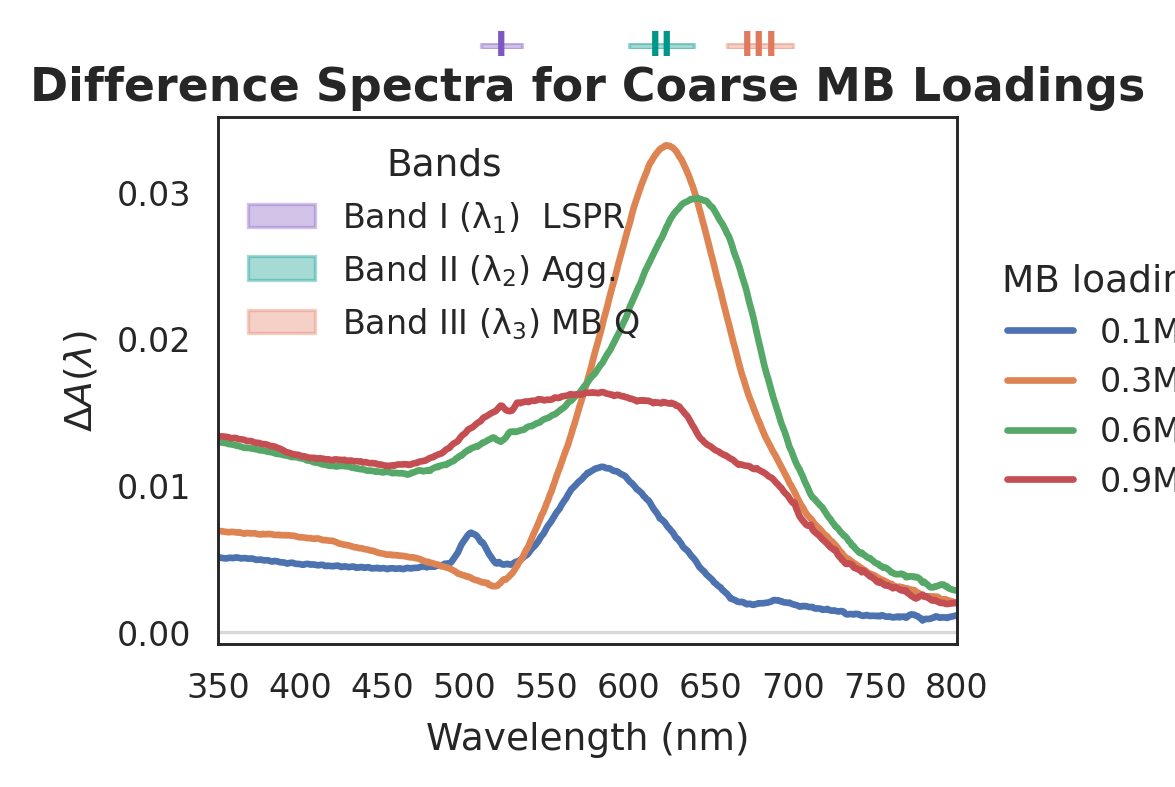

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path

# ===== Inputs =====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

PATHLENGTH_CM = 1.0
k_by_loading = {"0.1MB": 1.0, "0.3MB": 1.0, "0.6MB": 1.0, "0.9MB": 1.0}

GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
USE_SMOOTH = True
SG_WINDOW, SG_POLY = 11, 2

# Bands
LSPR_BAND = (510, 535)
AGG_BAND  = (600, 640)
MB_BAND   = (660, 700)

# ===== Load and prep =====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = [(t, f"{t}_AuNP", f"{t}_AuNP_As")
         for t in tags if f"{t}_AuNP" in df.columns and f"{t}_AuNP_As" in df.columns]

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def normalize_pathlength(A, l_cm):
    return A if l_cm == 1.0 else A * (1.0 / l_cm)

curves = []
for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    dA = A_as_g - k * A_blank_g
    if USE_SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    curves.append((tag, dA))

dA_all = np.vstack([c[1] for c in curves])
ymin, ymax = float(np.nanmin(dA_all)), float(np.nanmax(dA_all))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)

# ===== Plot (visual only, data unchanged) =====
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

inch = 1/25.4
fig, ax = plt.subplots(figsize=(90*inch, 58*inch), dpi=300)

# Curves
colors = {"0.1MB": "C0", "0.3MB": "C1", "0.6MB": "C2", "0.9MB": "C3"}
for tag, dA in curves:
    ax.plot(grid, dA, label=tag, color=colors[tag], lw=1.6)

# Axes
ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_ylim(ymin - pad, ymax + pad*1.2)
ax.axhline(0, color="0.85", lw=0.8, zorder=0)

ax.set_xticks(np.arange(350, 801, 50))
ax.set_xlabel("Wavelength (nm)", fontsize=9)
ax.set_ylabel(r"$\Delta A(\lambda)$", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=8)
ax.grid(False)  # drop gray vertical lines

# ---- Top ribbon for bands (colored, outside data) ----
ax_band = inset_axes(
    ax, width="100%", height="9%", loc="upper left",
    bbox_to_anchor=(0, 1.02, 1, 0.12), bbox_transform=ax.transAxes, borderpad=0
)
ax_band.set_xlim(GRID_MIN, GRID_MAX)
ax_band.set_ylim(0, 1)
for spine in ax_band.spines.values():
    spine.set_visible(False)
ax_band.set_xticks([]); ax_band.set_yticks([])

band_specs = [
    ("Band I (λ$_1$)  LSPR",  LSPR_BAND, "#7E57C2"),  # purple
    ("Band II (λ$_2$) Agg.",  AGG_BAND,  "#009688"),  # teal
    ("Band III (λ$_3$) MB Q", MB_BAND,   "#E07A5F"),  # terracotta
]
band_handles = []
for name, (x0, x1), col in band_specs:
    ax_band.axvspan(x0, x1, color=col, alpha=0.35)
    ax_band.text((x0+x1)/2, 0.5, name.split()[1], ha="center", va="center",
                 fontsize=8, weight="bold", color=col)  # shows λi inside block
    band_handles.append(mpatches.Patch(color=col, alpha=0.35, label=name))

# Legends
leg_samples = ax.legend(title="MB loading", frameon=False, loc="center left",
                        bbox_to_anchor=(1.02, 0.5), fontsize=8, title_fontsize=9)
ax.add_artist(leg_samples)
ax.legend(handles=band_handles, title="Bands", frameon=False,
          loc="upper left", fontsize=8, title_fontsize=9)

# Title and spacing
ax.set_title("Difference Spectra for Coarse MB Loadings", fontsize=11, weight="semibold", pad=4)
fig.subplots_adjust(right=0.82)
plt.show()



#Fine Optimization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: array of sample points is empty

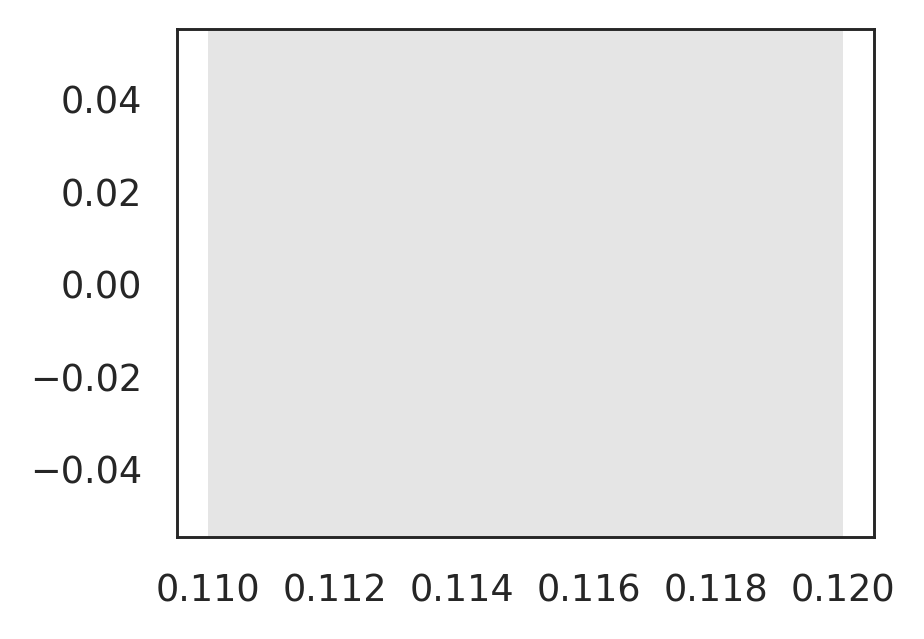

In [32]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from pathlib import Path

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250728_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

PATHLENGTH_CM = 1.0
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
SMOOTH = True
SG_WINDOW, SG_POLY = 11, 2

# Bands (nm) for selectivity index
AGG_BAND = (600, 640)   # aggregation band
MB_BAND  = (660, 700)   # MB dye band

# ==== Load data ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

# Infer tags automatically (e.g., "0.10MB", "0.11MB" ... etc.)
tags = sorted(set([c.replace("_AuNP","") for c in df.columns if "_AuNP" in c]))
pairs = [(tag, f"{tag}_AuNP", f"{tag}_AuNP_As")
         for tag in tags if f"{tag}_AuNP" in df.columns and f"{tag}_AuNP_As" in df.columns]

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(wl_src, A_src, wl_tgt):
    return np.interp(wl_tgt, wl_src, A_src)

def integrate_band(wl, y, band):
    mask = (wl >= band[0]) & (wl <= band[1])
    return np.trapz(y[mask], wl[mask])

# ==== Compute Selectivity Index for each MB loading ====
results = []
wl_src = df["Wavelength"].to_numpy()

for tag, bcol, acol in pairs:
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    # Normalize pathlength + grid
    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as, grid)

    # Differential absorbance
    dA = A_as_g - A_blank_g
    if SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    # Integrals
    agg_area = integrate_band(grid, dA, AGG_BAND)
    mb_area  = integrate_band(grid, dA, MB_BAND)
    si = agg_area / (mb_area + 1e-6)

    # Save
    mb_val = float(tag.replace("MB",""))   # convert tag like "0.11MB" -> 0.11
    results.append((mb_val, si))

si_df = pd.DataFrame(results, columns=["MB_volume", "SelectivityIndex"]).sort_values("MB_volume")
# Force both columns to float
si_df["MB_volume"] = pd.to_numeric(si_df["MB_volume"], errors="coerce").astype(float)
si_df["SelectivityIndex"] = pd.to_numeric(si_df["SelectivityIndex"], errors="coerce").astype(float)

# Drop any rows that failed conversion
si_df = si_df.dropna(subset=["MB_volume", "SelectivityIndex"])


# ==== Plot ====
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
PNG = f"{OUT_DIR}/fine_pass_selectivity.png"
PDF = f"{OUT_DIR}/fine_pass_selectivity.pdf"

sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 8,
    "axes.linewidth": 0.7,
})

fig, ax = plt.subplots(figsize=(3,2.2))

ax.plot(si_df["MB_volume"], si_df["SelectivityIndex"], marker="o", color="#0072B2", lw=1.5)

# Highlight 0.11–0.12 region
ax.axvspan(0.11, 0.12, color="gray", alpha=0.2, lw=0)

# Hollow marker at 0.115 (interpolated, not measured)
ax.plot(0.115, np.interp(0.115, si_df["MB_volume"], si_df["SelectivityIndex"]),
        marker="o", markersize=6, mfc="white", mec="red", mew=1.0, label="0.115 interpolated")

ax.set_xlabel("MB loading (mL)")
ax.set_ylabel("Selectivity Index (600–640 nm / 660–700 nm)")
ax.set_xlim(0.10, 0.20)

# Legend
ax.legend(frameon=False, fontsize=7, loc="upper right")

sns.despine(ax=ax)
plt.tight_layout()

plt.savefig(PNG, dpi=300, bbox_inches="tight")
plt.savefig(PDF, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", PNG, PDF)


In [34]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ==== Inputs ====
FINE_CSV = "/content/drive/MyDrive/RegeneronSTS/data/20250728_UVScans.csv"
COARSE_CSV = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"  # for 0.30 mL ref
OUT_DIR = "/content/drive/MyDrive/RegeneronSTS/figures"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# Pathlength (cm). If your cuvette differs, set here.
PATHLENGTH_CM = 1.0

# Wavelength integration windows
WIN_NUM = (600, 640)
WIN_DEN = (660, 700)

# Grid for interpolation
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
GRID = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

# ---- Helpers ----
def interp_to_grid(wl_src, A_src, wl_tgt):
    return np.interp(wl_tgt, wl_src, A_src)

def normalize_pathlength(A, path_cm):
    return A if path_cm == 1.0 else A * (1.0 / path_cm)

def k_from_mb_vol(mb_ml):
    # V0 = 2.5 AuNP + 2.5 MQ + MB
    V0 = 2.5 + 2.5 + float(mb_ml)
    Vf = V0 + 2.5
    return V0 / Vf

def compute_deltaA(df, tag, wl_col="Wavelength"):
    """Compute ΔA = A_As − k*A_blank for a given tag like '0.12MB'."""
    bcol = f"{tag}_AuNP"
    acol = f"{tag}_AuNP_As"
    if bcol not in df.columns or acol not in df.columns:
        return None, None
    wl = pd.to_numeric(df[wl_col], errors="coerce").to_numpy()
    A_b = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_a = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    # Pathlength normalization and interpolation to 1 nm grid
    A_b = normalize_pathlength(A_b, PATHLENGTH_CM)
    A_a = normalize_pathlength(A_a, PATHLENGTH_CM)
    A_b = interp_to_grid(wl, A_b, GRID)
    A_a = interp_to_grid(wl, A_a, GRID)

    # Parse MB volume from tag like '0.12MB'
    mb_ml = float(tag.replace("MB", ""))
    k = k_from_mb_vol(mb_ml)

    dA = A_a - k * A_b
    return GRID, dA

def integrate_window(wl, y, wstart, wend):
    mask = (wl >= wstart) & (wl <= wend)
    if not np.any(mask):
        return np.nan
    return np.trapz(y[mask], wl[mask])

def selectivity_index(wl, dA, eps=1e-9):
    num = integrate_window(wl, dA, *WIN_NUM)
    den = integrate_window(wl, dA, *WIN_DEN)
    return num / (den + eps)

# ---- Load fine-pass data and compute SI for 0.10–0.20 in 0.01 steps ----
df_fine = pd.read_csv(FINE_CSV)
df_fine.columns = [c.strip() for c in df_fine.columns]
df_fine["Wavelength"] = pd.to_numeric(df_fine["Wavelength"], errors="coerce")
df_fine = df_fine.dropna(subset=["Wavelength"]).sort_values("Wavelength")

volumes = [round(0.10 + 0.01*i, 2) for i in range(11)]  # 0.10..0.20
tags = [f"{v:.2f}MB" for v in volumes]

xs, ys = [], []
for tag, v in zip(tags, volumes):
    wl, dA = compute_deltaA(df_fine, tag)
    if wl is None:
        continue
    si = selectivity_index(wl, dA)
    xs.append(v)
    ys.append(si)

fine_df = pd.DataFrame({"MB_mL": xs, "SI": ys}).sort_values("MB_mL")

# ---- Compute coarse-pass 0.30 mL reference SI from the coarse file ----
df_coarse = pd.read_csv(COARSE_CSV)
df_coarse.columns = [c.strip() for c in df_coarse.columns]
df_coarse["Wavelength"] = pd.to_numeric(df_coarse["Wavelength"], errors="coerce")
df_coarse = df_coarse.dropna(subset=["Wavelength"]).sort_values("Wavelength")

wl_03, dA_03 = compute_deltaA(df_coarse, "0.30MB")
si_03 = selectivity_index(wl_03, dA_03) if wl_03 is not None else np.nan

# ---- Interpolated point at 0.115 mL (not measured) ----
# Use simple linear interpolation on the measured SI curve
x_interp = 0.115
si_interp = np.interp(x_interp, fine_df["MB_mL"].to_numpy(), fine_df["SI"].to_numpy())

# ==== Plot Figure B ====
plt.rcParams.update({
    "figure.dpi": 300,
    "font.family": "Arial",
    "axes.linewidth": 0.8,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
})

fig_w, fig_h = 6.0, 3.6  # inches, clear single-panel
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Shaded band 0.11–0.12
band = ax.axvspan(0.11, 0.12, color="gray", alpha=0.15)

# Measured points
pts = ax.plot(fine_df["MB_mL"], fine_df["SI"], linestyle="none",
              marker="o", markersize=5.5, color="#1f77b4", label="Measured points")

# Interpolated 0.115 (hollow red)
interp_pt = ax.plot([x_interp], [si_interp], linestyle="none",
                    marker="o", markersize=7, markerfacecolor="white",
                    markeredgecolor="red", markeredgewidth=1.4,
                    label="Interpolated 0.115")

# Reference line for 0.30 mL SI
ref = ax.axhline(si_03, color="black", lw=1.2, linestyle="--", label="0.30 reference")

# Annotations
ax.text(x_interp + 0.002, si_interp, "0.115 interpolated (not measured)",
        va="center", fontsize=8, color="red")

# Axes
ax.set_xlim(0.10, 0.20)
ax.set_xticks(np.round(np.arange(0.10, 0.201, 0.01), 2))
ax.set_xlabel("MB volume (mL)")
ax.set_ylabel("Selectivity Index (SI)")

# Natural y limits with small pad
ymin, ymax = fine_df["SI"].min(), fine_df["SI"].max()
rng = ymax - ymin if ymax > ymin else 1.0
ax.set_ylim(ymin - 0.08*rng, ymax + 0.12*rng)

# Title
ax.set_title("Fine-pass MB optimization: Selectivity Index (600–640 vs 660–700 nm)")

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor="#1f77b4", markeredgecolor="#1f77b4",
           markersize=6, label="Measured points"),
    Line2D([0], [0], marker='o', color='none', markerfacecolor="white", markeredgecolor="red",
           markeredgewidth=1.4, markersize=7, label="Interpolated 0.115"),
    Line2D([0], [0], color='black', lw=1.2, linestyle='--', label="0.30 reference"),
    Patch(facecolor="gray", alpha=0.15, label="Shaded 0.11–0.12 band")
]
ax.legend(handles=legend_elements, frameon=False, loc="upper right")

# Tidy style
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()

png = f"{OUT_DIR}/fine_pass_selectivity_index.png"
pdf = f"{OUT_DIR}/fine_pass_selectivity_index.pdf"
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:")
print(png)
print(pdf)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: array of sample points is empty

/tmp/ipython-input-4234758071.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y[m], wl[m])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


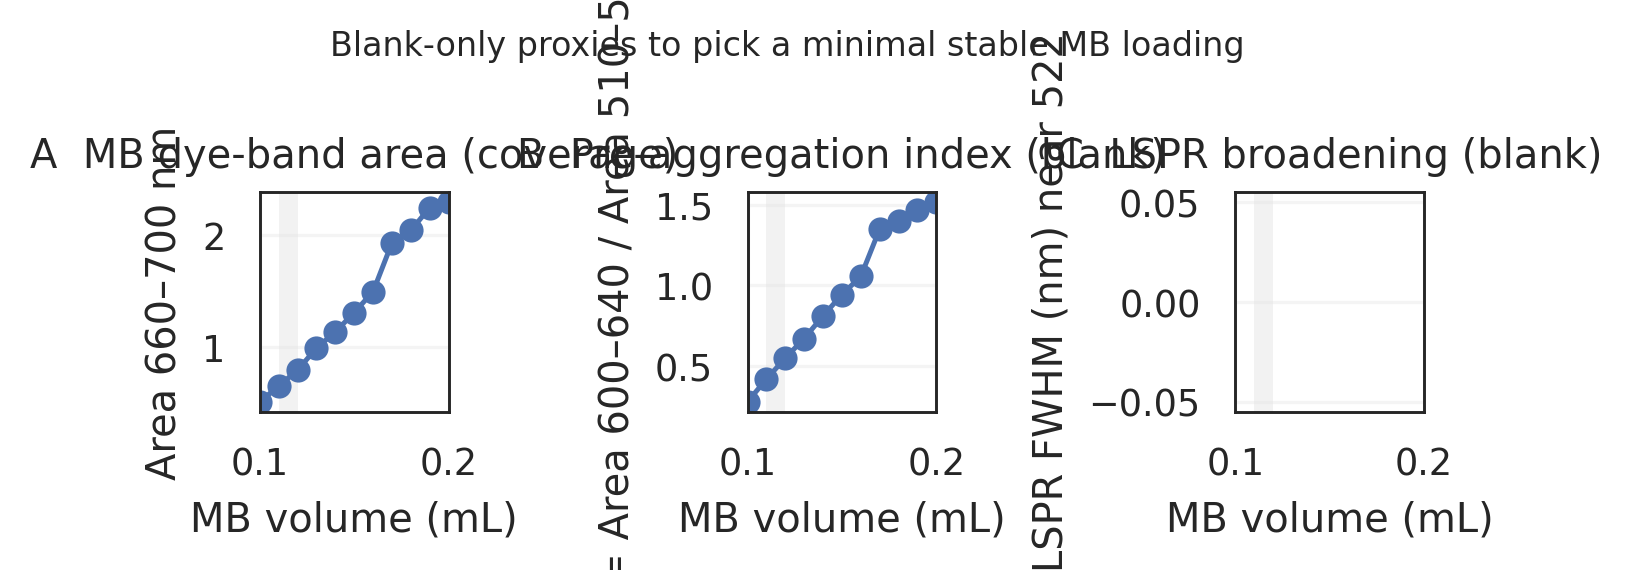

Saved: /content/drive/MyDrive/RegeneronSTS/figures/fine_pass_blank_proxies.png /content/drive/MyDrive/RegeneronSTS/figures/fine_pass_blank_proxies.pdf


In [35]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250728_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

# Wavelength grid and bands (nm)
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
LSPR_BAND = (510, 535)   # AuNP plasmon window for PAI denominator
AGG_BAND  = (600, 640)   # aggregation window for PAI numerator
MB_BAND   = (660, 700)   # MB dye band for coverage proxy
# Wider search window to find the LSPR peak for FWHM calc
LSPR_SEARCH = (500, 560)

# ==== Load data ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
assert "Wavelength" in df.columns, "CSV must include a 'Wavelength' column."

df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

# Identify blank (no As) spectra columns: anything ending in _AuNP except the bare 'AuNP' baseline if present
blank_cols = [c for c in df.columns if c.endswith("_AuNP") and c != "AuNP"]

# Extract numeric MB volumes (e.g., '0.11MB_AuNP' -> 0.11)
def mb_from_col(col):
    m = re.search(r"([\d.]+)\s*MB", col, re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

volumes = [mb_from_col(c) for c in blank_cols]
# Keep only columns that parsed successfully
keep = [i for i,v in enumerate(volumes) if not np.isnan(v)]
blank_cols = [blank_cols[i] for i in keep]
volumes    = [volumes[i]    for i in keep]

# Common grid
wl_src = df["Wavelength"].to_numpy()
grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def band_area(wl, y, band):
    m = (wl >= band[0]) & (wl <= band[1])
    if not np.any(m):
        return np.nan
    return np.trapz(y[m], wl[m])

def fwhm_in_window(wl, y, search_window):
    """Compute FWHM around the max within search_window; returns np.nan if bounds not found."""
    m = (wl >= search_window[0]) & (wl <= search_window[1])
    if not np.any(m):
        return np.nan
    xs, ys = wl[m], y[m]
    i_max = np.argmax(ys)
    y_max = ys[i_max]
    if not np.isfinite(y_max) or y_max <= 0:
        return np.nan
    half = y_max / 2.0

    # Left crossing
    left_idx = np.nan
    for i in range(i_max, 0, -1):
        if ys[i-1] <= half <= ys[i] or ys[i] <= half <= ys[i-1]:
            # linear interp between points i-1 and i
            x1, y1, x2, y2 = xs[i-1], ys[i-1], xs[i], ys[i]
            if y2 != y1:
                left_x = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
                left_idx = left_x
            break

    # Right crossing
    right_idx = np.nan
    for i in range(i_max, len(xs)-1):
        if ys[i] <= half <= ys[i+1] or ys[i+1] <= half <= ys[i]:
            x1, y1, x2, y2 = xs[i], ys[i], xs[i+1], ys[i+1]
            if y2 != y1:
                right_x = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
                right_idx = right_x
            break

    if np.isnan(left_idx) or np.isnan(right_idx):
        return np.nan
    return right_idx - left_idx

# Compute proxies for each blank spectrum
records = []
for col, vol in zip(blank_cols, volumes):
    A = pd.to_numeric(df[col], errors="coerce").to_numpy()
    A_g = interp_to_grid(wl_src, A, grid)

    # Areas
    area_lspr = band_area(grid, A_g, LSPR_BAND)
    area_agg  = band_area(grid, A_g, AGG_BAND)
    area_mb   = band_area(grid, A_g, MB_BAND)

    # PAI: aggregation/lspr (lower is better for blank stability)
    pai = area_agg / area_lspr if (area_lspr is not None and area_lspr != 0) else np.nan

    # FWHM near λ1
    width = fwhm_in_window(grid, A_g, LSPR_SEARCH)

    records.append((vol, area_mb, pai, width))

res = pd.DataFrame(records, columns=["MB_volume", "MB_area_660_700", "PAI", "LSPR_FWHM"])
res = res.sort_values("MB_volume").reset_index(drop=True)

# ==== Plot: three concise panels ====
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
PNG = f"{OUT_DIR}/fine_pass_blank_proxies.png"
PDF = f"{OUT_DIR}/fine_pass_blank_proxies.pdf"

plt.rcParams.update({
    "figure.dpi": 300,
    "font.size": 7,      # small default font
})

inch = 1/25.4
fig, axes = plt.subplots(1, 3, figsize=(120*inch, 45*inch))  # ~120 mm × 45 mm strip
(ax1, ax2, ax3) = axes

# Panel A: MB_area (coverage proxy)
ax1.plot(res["MB_volume"], res["MB_area_660_700"], marker="o", lw=1.2)
ax1.axvspan(0.11, 0.12, color="0.9", alpha=0.5, lw=0)  # highlight the knee region
ax1.set_xlabel("MB volume (mL)")
ax1.set_ylabel("Area 660–700 nm")
ax1.set_title("A  MB dye-band area (coverage)")

# Panel B: PAI (pre-aggregation index)
ax2.plot(res["MB_volume"], res["PAI"], marker="o", lw=1.2)
ax2.axvspan(0.11, 0.12, color="0.9", alpha=0.5, lw=0)
ax2.set_xlabel("MB volume (mL)")
ax2.set_ylabel("PAI = Area 600–640 / Area 510–535")
ax2.set_title("B  Pre-aggregation index (blank)")

# Panel C: LSPR FWHM (broadening)
ax3.plot(res["MB_volume"], res["LSPR_FWHM"], marker="o", lw=1.2)
ax3.axvspan(0.11, 0.12, color="0.9", alpha=0.5, lw=0)
ax3.set_xlabel("MB volume (mL)")
ax3.set_ylabel("LSPR FWHM (nm) near 522")
ax3.set_title("C  LSPR broadening (blank)")

# Shared x-limits if desired
for ax in axes:
    ax.set_xlim(0.10, 0.20)
    ax.grid(alpha=0.2)

fig.suptitle("Blank-only proxies to pick a minimal stable MB loading", fontsize=8, y=1.02)
fig.tight_layout()
plt.savefig(PNG, bbox_inches="tight")
plt.savefig(PDF, bbox_inches="tight")
plt.show()

print("Saved:", PNG, PDF)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-23930507.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y[m], wl[m])


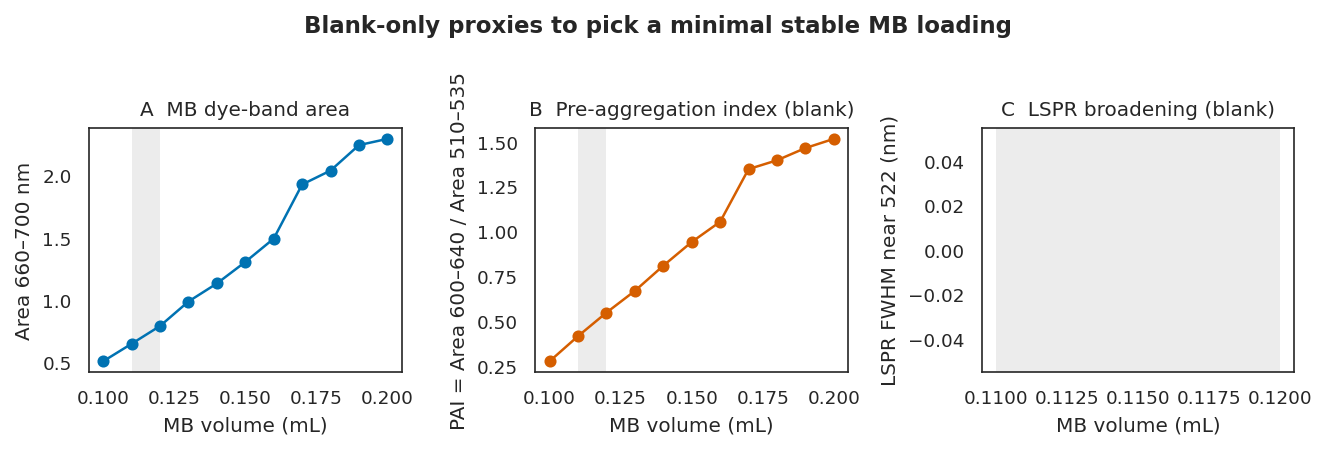

In [36]:
# ==== Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ==== Imports ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250728_UVScans.csv"

# Wavelength grid and bands (nm)
GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
LSPR_BAND   = (510, 535)   # AuNP plasmon window for PAI denominator
AGG_BAND    = (600, 640)   # aggregation window for PAI numerator
MB_BAND     = (660, 700)   # MB dye band for coverage proxy
LSPR_SEARCH = (500, 560)   # wider window to locate plasmon for FWHM

# ==== Load data ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
assert "Wavelength" in df.columns, "CSV must include a 'Wavelength' column."

df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

# Identify blank spectra columns (no As): anything ending in "_AuNP" except bare "AuNP"
blank_cols = [c for c in df.columns if c.endswith("_AuNP") and c != "AuNP"]

# Parse numeric MB volumes, e.g., "0.11MB_AuNP" -> 0.11
def parse_mb(col):
    m = re.search(r"([\d.]+)\s*MB", col, flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

mb_vals = np.array([parse_mb(c) for c in blank_cols], dtype=float)
keep = ~np.isnan(mb_vals)
blank_cols = [c for c, k in zip(blank_cols, keep) if k]
mb_vals = mb_vals[keep]

# Common grid
wl_src = df["Wavelength"].to_numpy()
grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def band_area(wl, y, band):
    m = (wl >= band[0]) & (wl <= band[1])
    if not np.any(m):
        return np.nan
    return np.trapz(y[m], wl[m])

def fwhm_in_window(wl, y, search_window):
    """FWHM around the local max within search_window. Returns np.nan if not resolvable."""
    m = (wl >= search_window[0]) & (wl <= search_window[1])
    if not np.any(m):
        return np.nan
    xs, ys = wl[m], y[m]
    i_max = int(np.nanargmax(ys))
    y_max = ys[i_max]
    if not np.isfinite(y_max) or y_max <= 0:
        return np.nan
    half = y_max / 2.0

    # Left crossing
    left_x = np.nan
    for i in range(i_max, 0, -1):
        y1, y2 = ys[i-1], ys[i]
        if (y1 - half) * (y2 - half) <= 0 and y2 != y1:
            x1, x2 = xs[i-1], xs[i]
            left_x = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            break

    # Right crossing
    right_x = np.nan
    for i in range(i_max, len(xs) - 1):
        y1, y2 = ys[i], ys[i+1]
        if (y1 - half) * (y2 - half) <= 0 and y2 != y1:
            x1, x2 = xs[i], xs[i+1]
            right_x = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            break

    if np.isnan(left_x) or np.isnan(right_x):
        return np.nan
    return right_x - left_x

# Compute proxies for each blank spectrum
mb_area_list, pai_list, fwhm_list = [], [], []
for col in blank_cols:
    A = pd.to_numeric(df[col], errors="coerce").to_numpy()
    A_g = interp_to_grid(wl_src, A, grid)

    area_mb   = band_area(grid, A_g, MB_BAND)     # dye coverage proxy
    area_lspr = band_area(grid, A_g, LSPR_BAND)   # denominator for PAI
    area_agg  = band_area(grid, A_g, AGG_BAND)    # numerator for PAI

    pai = area_agg / area_lspr if (np.isfinite(area_lspr) and area_lspr != 0) else np.nan
    width = fwhm_in_window(grid, A_g, LSPR_SEARCH)

    mb_area_list.append(area_mb)
    pai_list.append(pai)
    fwhm_list.append(width)

mb_area_list = np.array(mb_area_list, dtype=float)
pai_list     = np.array(pai_list, dtype=float)
fwhm_list    = np.array(fwhm_list, dtype=float)

# Sort by MB volume for clean plotting
order = np.argsort(mb_vals)
mb_vals = mb_vals[order]
mb_area_list = mb_area_list[order]
pai_list     = pai_list[order]
fwhm_list    = fwhm_list[order]

# ==== Plot nicely in Colab (inline only) ====
plt.rcParams.update({
    "figure.dpi": 150,
    "font.size": 9,
    "axes.linewidth": 0.8,
})

fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # three readable panels

# Panel A: MB dye-band area (coverage proxy)
axes[0].plot(mb_vals, mb_area_list, "o-", color="#0072B2")
axes[0].axvspan(0.11, 0.12, color="gray", alpha=0.15, lw=0)
axes[0].set_xlabel("MB volume (mL)")
axes[0].set_ylabel("Area 660–700 nm")
axes[0].set_title("A  MB dye-band area")

# Panel B: Pre-aggregation index PAI = area(600–640) / area(510–535)
axes[1].plot(mb_vals, pai_list, "o-", color="#D55E00")
axes[1].axvspan(0.11, 0.12, color="gray", alpha=0.15, lw=0)
axes[1].set_xlabel("MB volume (mL)")
axes[1].set_ylabel("PAI = Area 600–640 / Area 510–535")
axes[1].set_title("B  Pre-aggregation index (blank)")

# Panel C: LSPR FWHM near 522 nm
axes[2].plot(mb_vals, fwhm_list, "o-", color="#009E73")
axes[2].axvspan(0.11, 0.12, color="gray", alpha=0.15, lw=0)
axes[2].set_xlabel("MB volume (mL)")
axes[2].set_ylabel("LSPR FWHM near 522 (nm)")
axes[2].set_title("C  LSPR broadening (blank)")

fig.suptitle("Blank-only proxies to pick a minimal stable MB loading", fontsize=11, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
